In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


In [2]:
#Read 2016-2019 and 2020 data
answers = pd.read_csv('./data/Answer.csv')
survey_2020 = pd.read_csv('./data/2020-survey.csv')

#The chosen question numbers
chosen_features = [1, 2, 5, 6, 7, 8, 9, 13, 17, 18, 19]

### Formating 2020 survey

In [3]:
#Filtering out removed questions and adding year column.
unused_questions_removed = survey_2020.columns[survey_2020.columns.str.startswith('q')]
survey_2020 = survey_2020[unused_questions_removed]
survey_2020 = survey_2020[['q1', 'q2', 'q5', 'q6', 'q7', 'q8', 'q9', 'q13', 'q17', 'q18', 'q19']]
survey_2020['Year'] = '2020'
survey_2020

,q1,q2,q5,q6,q7,q8,q9,q13,q17,q18,q19,Year
0,45,Male,1,Yes,0,NaN,NaN,NaN,NaN,NaN,NaN,2020
1,24,female,1,Yes,1,NaN,NaN,NaN,NaN,NaN,NaN,2020
2,46,Male,1,Yes,0,NaN,NaN,NaN,NaN,NaN,NaN,2020
3,25,Female,1,Yes,0,NaN,NaN,NaN,NaN,NaN,NaN,2020
4,25,F,1,I don't know,0,NaN,NaN,NaN,NaN,NaN,NaN,2020
...,...,...,...,...,...,...,...,...,...,...,...,...
175,53,Male,0,No,0,More than 1000,0.0,1.0,Somewhat difficult,No,No,2020
176,23,F,0,No,0,26-100,1.0,1.0,Very easy,Maybe,Maybe,2020
177,34,Male,0,Yes,1,100-500,1.0,1.0,Somewhat easy,Maybe,Maybe,2020
178,43,Male,0,Yes,1,500-1000,0.0,1.0,Difficult,Maybe,No,2020


## Filter out removed questions

In [4]:
answers = answers[answers['QuestionID'].isin(chosen_features)]

## Create survey DataFrame

We want a data frame where each row will represent one users answers to one survey. We create a empty DataFrame and fill it out with one row for each unique UserID found in the answers table.

In [5]:
surveys = pd.DataFrame(columns=['q1', 'q2', 'q5', 'q6', 'q7', 'q8', 'q9', 'q13', 'q17', 'q18', 'q19', 'Year'])
user_ids = answers['UserID'].unique()
surveys['UserID'] = user_ids
surveys

,q1,q2,q5,q6,q7,q8,q9,q13,q17,q18,q19,Year,UserID
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4213,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4214
4214,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4215
4215,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4216
4216,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4217


In order to fill out the survey DataFrame we have to iterate through each row in the answers table and set the values in the corresponding row in surveys.

In [6]:
for answer in answers.iterrows():
    user_id = answer[1][2]
    question_id = 'q' + str(answer[1][3])
    answer_text = answer[1][0]
    year = answer[1][1]
    surveys.at[user_id - 1, question_id] = answer_text
    surveys.at[user_id - 1, 'Year'] = year
    
    

### Removing 2014 survey
The 2014 study does not contain some questions about communication

In [7]:
surveys = surveys[surveys['Year'] != 2014]
surveys

,q1,q2,q5,q6,q7,q8,q9,q13,q17,q18,q19,Year,UserID
1260,39,Male,0,No,0,26-100,1,-1,Very easy,Maybe,Yes,2016,1261
1261,29,Male,0,Yes,1,6-25,1,-1,Somewhat easy,Maybe,Yes,2016,1262
1262,38,Male,0,No,1,6-25,1,-1,Neither easy nor difficult,Maybe,Maybe,2016,1263
1263,43,Male,1,No,1,-1,-1,-1,-1,-1,-1,2016,1264
1264,43,Female,0,Yes,1,6-25,0,1,Neither easy nor difficult,Maybe,No,2016,1265
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4213,27,male,0,No,0,More than 1000,0,1,Somewhat difficult,No,No,2019,4214
4214,48,Male,1,No,0,-1,-1,-1,-1,-1,-1,2019,4215
4215,50,Male,1,No,0,-1,-1,-1,-1,-1,-1,2019,4216
4216,30,female,0,No,0,More than 1000,1,1,Difficult,Maybe,No,2019,4217


### Concat 2020 study to the surveys DataFrame

In [8]:
surveys = pd.concat([surveys, survey_2020])
surveys

,q1,q2,q5,q6,q7,q8,q9,q13,q17,q18,q19,Year,UserID
1260,39,Male,0,No,0,26-100,1,-1,Very easy,Maybe,Yes,2016,1261.0
1261,29,Male,0,Yes,1,6-25,1,-1,Somewhat easy,Maybe,Yes,2016,1262.0
1262,38,Male,0,No,1,6-25,1,-1,Neither easy nor difficult,Maybe,Maybe,2016,1263.0
1263,43,Male,1,No,1,-1,-1,-1,-1,-1,-1,2016,1264.0
1264,43,Female,0,Yes,1,6-25,0,1,Neither easy nor difficult,Maybe,No,2016,1265.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,53,Male,0,No,0,More than 1000,0.0,1.0,Somewhat difficult,No,No,2020,NaN
176,23,F,0,No,0,26-100,1.0,1.0,Very easy,Maybe,Maybe,2020,NaN
177,34,Male,0,Yes,1,100-500,1.0,1.0,Somewhat easy,Maybe,Maybe,2020,NaN
178,43,Male,0,Yes,1,500-1000,0.0,1.0,Difficult,Maybe,No,2020,NaN


### Drop UserID column
The UserID column is not needed anymore

In [9]:
surveys = surveys.drop('UserID', axis=1)
surveys

,q1,q2,q5,q6,q7,q8,q9,q13,q17,q18,q19,Year
1260,39,Male,0,No,0,26-100,1,-1,Very easy,Maybe,Yes,2016
1261,29,Male,0,Yes,1,6-25,1,-1,Somewhat easy,Maybe,Yes,2016
1262,38,Male,0,No,1,6-25,1,-1,Neither easy nor difficult,Maybe,Maybe,2016
1263,43,Male,1,No,1,-1,-1,-1,-1,-1,-1,2016
1264,43,Female,0,Yes,1,6-25,0,1,Neither easy nor difficult,Maybe,No,2016
...,...,...,...,...,...,...,...,...,...,...,...,...
175,53,Male,0,No,0,More than 1000,0.0,1.0,Somewhat difficult,No,No,2020
176,23,F,0,No,0,26-100,1.0,1.0,Very easy,Maybe,Maybe,2020
177,34,Male,0,Yes,1,100-500,1.0,1.0,Somewhat easy,Maybe,Maybe,2020
178,43,Male,0,Yes,1,500-1000,0.0,1.0,Difficult,Maybe,No,2020


### Drop NaN containing rows

In [10]:
print(surveys.shape)
surveys = surveys.dropna()
surveys.shape

(3138, 12)


(3112, 12)

### Change column names to feature names

In [11]:
surveys = surveys.rename(columns={
    'q1':'age', 'q2':'sex', 'q5':'self_employed',
    'q6':'family_history', 'q7':'sought_treatment',
    'q8':'org_size', 'q9':'tech_org', 
    'q13':'tech_primary_role', 'q17':'ask_for_leave', 
    'q18':'discussing_co', 'q19': 'discussing_s', 'Year': 'year'})
surveys

,age,sex,self_employed,family_history,sought_treatment,org_size,tech_org,tech_primary_role,ask_for_leave,discussing_co,discussing_s,year
1260,39,Male,0,No,0,26-100,1,-1,Very easy,Maybe,Yes,2016
1261,29,Male,0,Yes,1,6-25,1,-1,Somewhat easy,Maybe,Yes,2016
1262,38,Male,0,No,1,6-25,1,-1,Neither easy nor difficult,Maybe,Maybe,2016
1263,43,Male,1,No,1,-1,-1,-1,-1,-1,-1,2016
1264,43,Female,0,Yes,1,6-25,0,1,Neither easy nor difficult,Maybe,No,2016
...,...,...,...,...,...,...,...,...,...,...,...,...
175,53,Male,0,No,0,More than 1000,0.0,1.0,Somewhat difficult,No,No,2020
176,23,F,0,No,0,26-100,1.0,1.0,Very easy,Maybe,Maybe,2020
177,34,Male,0,Yes,1,100-500,1.0,1.0,Somewhat easy,Maybe,Maybe,2020
178,43,Male,0,Yes,1,500-1000,0.0,1.0,Difficult,Maybe,No,2020


### Convert some features to integers

In [12]:
surveys['sought_treatment'] = surveys['sought_treatment'].astype(int)
surveys['tech_org'] = surveys['tech_org'].astype(int)
surveys['tech_primary_role'] = surveys['tech_primary_role'].astype(int)
surveys['year'] = surveys['year'].astype(int)
surveys['self_employed'] = surveys['self_employed'].astype(int)


### Drop self employed people

In [13]:
surveys = surveys[surveys.self_employed != 1]
surveys = surveys.drop('self_employed', 1)
surveys

/var/folders/df/m28l7j3s02bfj9lndkyhbpth0000gn/T/ipykernel_34291/1038786952.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  surveys = surveys.drop('self_employed', 1)


,age,sex,family_history,sought_treatment,org_size,tech_org,tech_primary_role,ask_for_leave,discussing_co,discussing_s,year
1260,39,Male,No,0,26-100,1,-1,Very easy,Maybe,Yes,2016
1261,29,Male,Yes,1,6-25,1,-1,Somewhat easy,Maybe,Yes,2016
1262,38,Male,No,1,6-25,1,-1,Neither easy nor difficult,Maybe,Maybe,2016
1264,43,Female,Yes,1,6-25,0,1,Neither easy nor difficult,Maybe,No,2016
1265,42,Male,No,1,More than 1000,1,-1,Somewhat easy,Maybe,Yes,2016
...,...,...,...,...,...,...,...,...,...,...,...
175,53,Male,No,0,More than 1000,0,1,Somewhat difficult,No,No,2020
176,23,F,No,0,26-100,1,1,Very easy,Maybe,Maybe,2020
177,34,Male,Yes,1,100-500,1,1,Somewhat easy,Maybe,Maybe,2020
178,43,Male,Yes,1,500-1000,0,1,Difficult,Maybe,No,2020


## Age
Some age values are negative, therefore those entries will be changed to positive. Also, there are some unrealistic ages, those will be removed.

In [14]:
age_values = surveys['age'].value_counts()
age_values

30     160
28     138
32     126
31     124
29     121
      ... 
323      1
99       1
17       1
52       1
43       1
Name: age, Length: 92, dtype: int64

In [92]:
surveys['age'].isna().sum()

0

In [16]:

surveys['age'] = surveys['age'].astype(int)

In [17]:
surveys = surveys[surveys.age > 16]
surveys = surveys[surveys.age < 100]
age_values = surveys['age'].value_counts()
age_values
                        

30    171
28    144
32    138
31    130
29    127
34    121
27    121
37    121
35    121
33    115
26    113
36     96
38     94
39     90
40     84
24     81
25     79
42     75
41     57
23     57
45     53
44     52
22     52
43     41
46     39
47     32
49     26
21     24
48     19
50     16
52     14
51     13
55     12
53     12
20     11
54      7
57      7
19      7
61      5
62      4
56      4
58      3
59      3
63      3
60      2
66      2
18      1
64      1
99      1
70      1
74      1
17      1
65      1
Name: age, dtype: int64

## Gender
The surveys respondents have answered this question in free text format, there fore we had to change many entries to 'other' and group 'Male' and 'male' etc.

In [18]:
sex_values = surveys['sex'].value_counts()

surveys['sex'] = surveys['sex'].str.lower()
gender_values = surveys['sex'].value_counts()
pd.set_option('display.max_rows', 100)
gender_values

male                                       1783
female                                      694
-1                                           15
f                                            10
m                                             9
non-binary                                    8
nonbinary                                     8
agender                                       5
genderqueer                                   4
none                                          4
non binary                                    3
genderfluid                                   3
other                                         2
trans man                                     2
woman                                         2
masculino                                     1
swm                                           1
ostensibly male                               1
mostly male                                   1
transgender                                   1
female/gender non-binary.               

In [19]:
surveys['sex'] = np.where((surveys.sex == 'm'),'male',surveys.sex)
surveys['sex'] = np.where((surveys.sex == 'masculino'),'male',surveys.sex)
surveys['sex'] = np.where((surveys.sex == 'mail'),'male',surveys.sex)
surveys['sex'] = np.where((surveys.sex == 'cisgender male'),'male',surveys.sex)
surveys['sex'] = np.where((surveys.sex == 'cishet male'),'male',surveys.sex)

surveys['sex'] = np.where((surveys.sex == 'f'),'female',surveys.sex)
surveys['sex'] = np.where((surveys.sex == 'woman'),'female',surveys.sex)
surveys['sex'] = np.where((surveys.sex == 'femmina'),'female',surveys.sex)
surveys['sex'] = np.where((surveys.sex == 'female, she/her'),'female',surveys.sex)
surveys['sex'] = np.where((surveys.sex == 'fm'),'female',surveys.sex)

In [20]:
surveys['sex'] = np.where(((surveys.sex != 'male') & (surveys.sex != 'female')),'other',surveys.sex)
sex_values = surveys['sex'].value_counts()
sex_values

male      1795
female     709
other      101
Name: sex, dtype: int64

In [21]:
surveys.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2605 entries, 1260 to 179
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   age                2605 non-null   int64 
 1   sex                2605 non-null   object
 2   family_history     2605 non-null   object
 3   sought_treatment   2605 non-null   int64 
 4   org_size           2605 non-null   object
 5   tech_org           2605 non-null   int64 
 6   tech_primary_role  2605 non-null   int64 
 7   ask_for_leave      2605 non-null   object
 8   discussing_co      2605 non-null   object
 9   discussing_s       2605 non-null   object
 10  year               2605 non-null   int64 
dtypes: int64(5), object(6)
memory usage: 244.2+ KB


## Linear Regression

In [22]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics


### Converting categorical features to numerical

In [23]:
lr_surveys = surveys.copy()

lr_surveys['sex'] = lr_surveys['sex'].map({'male':1,'female':0, 'other':2})
lr_surveys['family_history'] = lr_surveys['family_history'].map({'Yes':1,'No':0, "I don't know":2})
lr_surveys['org_size'] = lr_surveys['org_size'].map({
    'More than 1000':6,'500-1000':5, 
    '100-500':4, '26-100':3, '6-25':2, 
    '1-5':1, '-1':0})
lr_surveys['ask_for_leave'] = lr_surveys['ask_for_leave'].map({
    'Very difficult':7, 'Difficult':6,'Somewhat difficult':5, 
    'Neither easy nor difficult':4, 'Somewhat easy':3, 'Very easy':2, 
    "I don't know":1, '-1':0})
lr_surveys['discussing_co'] = lr_surveys['discussing_co'].map({'Yes':1,'No':0, "Maybe":2, '-1': 3})
lr_surveys['discussing_s'] = lr_surveys['discussing_s'].map({'Yes':1,'No':0, "Maybe":2, '-1': 3})
lr_surveys

,age,sex,family_history,sought_treatment,org_size,tech_org,tech_primary_role,ask_for_leave,discussing_co,discussing_s,year
1260,39,1,0,0,3,1,-1,2,2,1,2016
1261,29,1,1,1,2,1,-1,3,2,1,2016
1262,38,1,0,1,2,1,-1,4,2,2,2016
1264,43,0,1,1,2,0,1,4,2,0,2016
1265,42,1,0,1,6,1,-1,3,2,1,2016
...,...,...,...,...,...,...,...,...,...,...,...
175,53,1,0,0,6,0,1,5,0,0,2020
176,23,0,0,0,3,1,1,2,2,2,2020
177,34,1,1,1,4,1,1,3,2,2,2020
178,43,1,1,1,5,0,1,6,2,0,2020


In [24]:
lr_surveys.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2605 entries, 1260 to 179
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype
---  ------             --------------  -----
 0   age                2605 non-null   int64
 1   sex                2605 non-null   int64
 2   family_history     2605 non-null   int64
 3   sought_treatment   2605 non-null   int64
 4   org_size           2605 non-null   int64
 5   tech_org           2605 non-null   int64
 6   tech_primary_role  2605 non-null   int64
 7   ask_for_leave      2605 non-null   int64
 8   discussing_co      2605 non-null   int64
 9   discussing_s       2605 non-null   int64
 10  year               2605 non-null   int64
dtypes: int64(11)
memory usage: 244.2 KB


### Splitting, training and results

In [25]:
independent_variables = [
    'age', 'sex', 'family_history', 'org_size', 
    'tech_org', 'tech_primary_role', 'ask_for_leave', 'discussing_co', 
    'discussing_s', 'year']
x = lr_surveys[independent_variables]
y = lr_surveys['sought_treatment']

train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=0.20, random_state=1)

lr_model = LogisticRegression(max_iter=200)

lr_model.fit(train_x, train_y)

predictions = lr_model.predict(test_x)

report = metrics.classification_report(test_y,predictions)
print(report)



              precision    recall  f1-score   support

           0       0.65      0.46      0.54       216
           1       0.68      0.83      0.75       305

    accuracy                           0.67       521
   macro avg       0.67      0.64      0.64       521
weighted avg       0.67      0.67      0.66       521



### Creating a plotting function

In [27]:
def plot_feature_importances(importances, names, model_type):
    feature_importances = np.array(importances)
    feature_names = np.array(names)
    
    data = {'feature_names': feature_names, 'feature_importances': feature_importances}
    feature_importances_df = pd.DataFrame(data)
    
    feature_importances_df.sort_values(by=['feature_importances'], ascending=False, inplace=True)
    
    plt.figure(figsize=(10,8))
    
    sns.barplot(x=feature_importances_df['feature_importances'], y=feature_importances_df['feature_names'])
    
    plt.title(model_type + 'Feature importances')
    plt.xlabel('Feature importances')
    plt.ylabel('Feature names')

### Feature coefficients

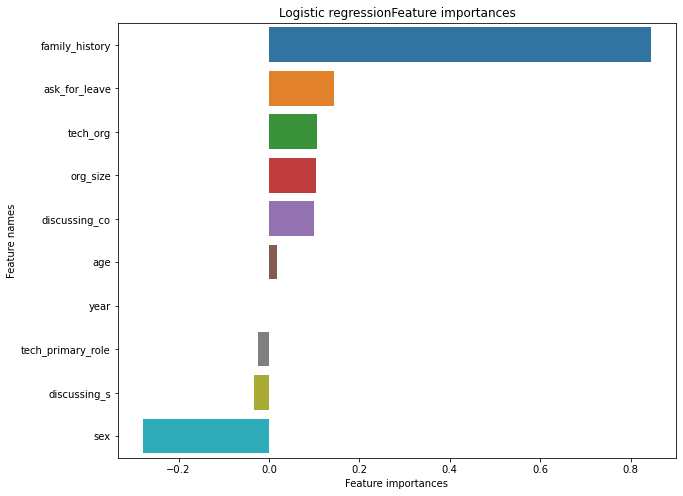

In [29]:
plot_feature_importances(lr_model.coef_[0], train_x.columns, "Logistic regression")

## Decision Tree and Random Forest

In [30]:
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, r2_score
from itertools import product

### Converting categorical features

In [32]:
rf_surveys = pd.get_dummies(surveys, columns=['sex', 'family_history', 'org_size', 'tech_primary_role', 'ask_for_leave', 'discussing_co', 'discussing_s'])
rf_surveys

,age,sought_treatment,tech_org,year,sex_female,sex_male,sex_other,family_history_I don't know,family_history_No,family_history_Yes,...,ask_for_leave_Somewhat difficult,ask_for_leave_Somewhat easy,ask_for_leave_Very difficult,ask_for_leave_Very easy,discussing_co_Maybe,discussing_co_No,discussing_co_Yes,discussing_s_Maybe,discussing_s_No,discussing_s_Yes
1260,39,0,1,2016,0,1,0,0,1,0,...,0,0,0,1,1,0,0,0,0,1
1261,29,1,1,2016,0,1,0,0,0,1,...,0,1,0,0,1,0,0,0,0,1
1262,38,1,1,2016,0,1,0,0,1,0,...,0,0,0,0,1,0,0,1,0,0
1264,43,1,0,2016,1,0,0,0,0,1,...,0,0,0,0,1,0,0,0,1,0
1265,42,1,1,2016,0,1,0,0,1,0,...,0,1,0,0,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,53,0,0,2020,0,1,0,0,1,0,...,1,0,0,0,0,1,0,0,1,0
176,23,0,1,2020,1,0,0,0,1,0,...,0,0,0,1,1,0,0,1,0,0
177,34,1,1,2020,0,1,0,0,0,1,...,0,1,0,0,1,0,0,1,0,0
178,43,1,0,2020,0,1,0,0,0,1,...,0,0,0,0,1,0,0,0,1,0


### Splitting data

In [33]:
x = rf_surveys.drop('sought_treatment', axis=1)
y = rf_surveys['sought_treatment'].values

train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=0.20, random_state=1)


### Tuning

Trying different parameter settings in order to optimize results.

In [34]:
max_depths = [None, 2, 3, 4, 5, 6, 7, 8,]
for depth in max_depths:
    dt_model = DecisionTreeClassifier(criterion='entropy',
                                      max_depth=depth,
                                      random_state=123)
    dt_model.fit(train_x, train_y)
    prediction = dt_model.predict(X=test_x)
    print('Accuracy on test set with max_depth = {}: {:.3f}'.format(depth, accuracy_score(test_y, prediction)))
    report = metrics.classification_report(test_y,prediction)
    print(report)

Accuracy on test set with max_depth = None: 0.608
              precision    recall  f1-score   support

           0       0.53      0.52      0.52       216
           1       0.66      0.67      0.67       305

    accuracy                           0.61       521
   macro avg       0.60      0.60      0.60       521
weighted avg       0.61      0.61      0.61       521

Accuracy on test set with max_depth = 2: 0.714
              precision    recall  f1-score   support

           0       0.70      0.54      0.61       216
           1       0.72      0.84      0.77       305

    accuracy                           0.71       521
   macro avg       0.71      0.69      0.69       521
weighted avg       0.71      0.71      0.71       521

Accuracy on test set with max_depth = 3: 0.712
              precision    recall  f1-score   support

           0       0.70      0.53      0.60       216
           1       0.72      0.84      0.77       305

    accuracy                          

### Creating tree
max_depth set to 2.

In [35]:
dt_model = DecisionTreeClassifier(criterion='entropy', max_depth=2, random_state=1)
dt_model.fit(train_x, train_y)

DecisionTreeClassifier(criterion='entropy', max_depth=2, random_state=1)

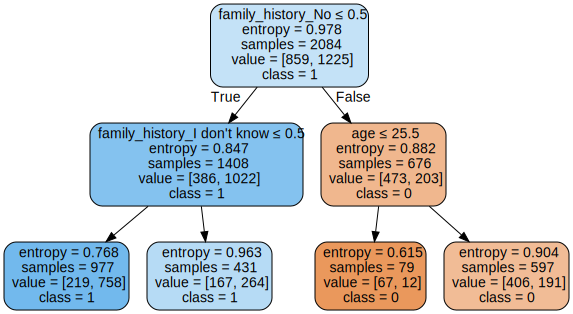

In [36]:
#Plotting tree

from graphviz import Source

tree_plot = Source(tree.export_graphviz(dt_model, out_file=None,
                               feature_names=x.columns,
                               class_names=rf_surveys['sought_treatment'].unique().astype(str),
                               filled=True, rounded=True,
                               special_characters=True))
tree_plot

### Decision tree feature importances

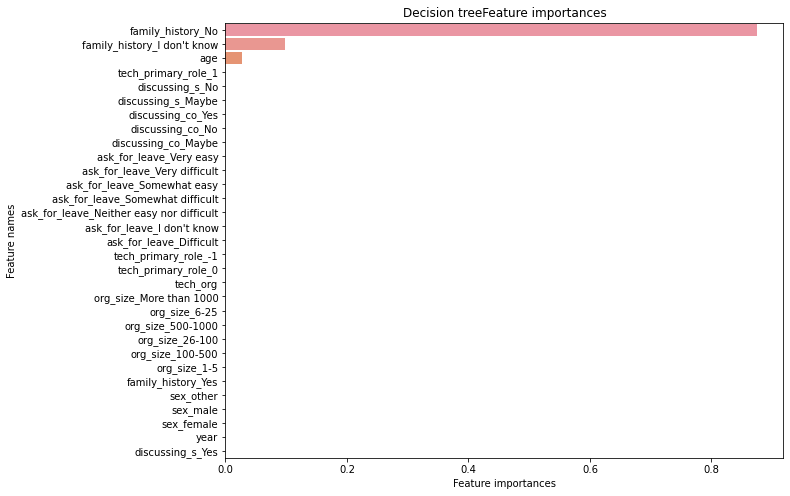

In [38]:
plot_feature_importances(dt_model.feature_importances_, train_x.columns, 'Decision tree')

In [39]:
#Accuracy
train_score = dt_model.score(train_x, train_y)
test_score = dt_model.score(test_x, test_y)
print(train_score)
test_score

0.7173704414587332


0.7140115163147792

In [41]:
#Results
pred = dt_model.predict(test_x)
report = metrics.classification_report(test_y,pred)
print(report)

              precision    recall  f1-score   support

           0       0.70      0.54      0.61       216
           1       0.72      0.84      0.77       305

    accuracy                           0.71       521
   macro avg       0.71      0.69      0.69       521
weighted avg       0.71      0.71      0.71       521



## Random Forest

### Tuning

In [113]:
from itertools import product
n_estimators = 300
max_features = [1, 'sqrt', 'log2']
max_depths = [None, 2, 3, 4, 5, 6, 7, 8]
for num_features, depth in product(max_features, max_depths):
    rf_model = RandomForestClassifier(n_estimators=n_estimators,
                                     criterion='entropy',
                                     max_features=num_features,
                                     max_depth= depth,
                                     n_jobs=2,
                                     random_state=123)
    rf_model.fit(train_x, train_y)
    prediction = rf_model.predict(X=test_x)
    print('Accuracy on test set with max features = {} and max_depth = {}: {:.3f}'.format(num_features, depth, accuracy_score(test_y, prediction)))
    report = metrics.classification_report(test_y,prediction)
    print(report)
    
        

Accuracy on test set with max features = 1 and max_depth = None: 0.679
              precision    recall  f1-score   support

           0       0.63      0.55      0.59       216
           1       0.71      0.77      0.74       305

    accuracy                           0.68       521
   macro avg       0.67      0.66      0.66       521
weighted avg       0.68      0.68      0.68       521

Accuracy on test set with max features = 1 and max_depth = 2: 0.585
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       216
           1       0.59      1.00      0.74       305

    accuracy                           0.59       521
   macro avg       0.29      0.50      0.37       521
weighted avg       0.34      0.59      0.43       521



/opt/homebrew/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy on test set with max features = 1 and max_depth = 3: 0.585
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       216
           1       0.59      1.00      0.74       305

    accuracy                           0.59       521
   macro avg       0.29      0.50      0.37       521
weighted avg       0.34      0.59      0.43       521



/opt/homebrew/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy on test set with max features = 1 and max_depth = 4: 0.599
              precision    recall  f1-score   support

           0       0.65      0.07      0.13       216
           1       0.60      0.97      0.74       305

    accuracy                           0.60       521
   macro avg       0.62      0.52      0.43       521
weighted avg       0.62      0.60      0.49       521

Accuracy on test set with max features = 1 and max_depth = 5: 0.653
              precision    recall  f1-score   support

           0       0.75      0.24      0.36       216
           1       0.64      0.94      0.76       305

    accuracy                           0.65       521
   macro avg       0.70      0.59      0.56       521
weighted avg       0.69      0.65      0.60       521

Accuracy on test set with max features = 1 and max_depth = 6: 0.687
              precision    recall  f1-score   support

           0       0.74      0.38      0.50       216
           1       0.67      0.91

In [46]:
#Training model with max_depth=6 and max_features='log2'

rf_model = RandomForestClassifier(n_estimators=300, criterion='entropy', max_depth=6, max_features='log2', random_state=123)
rf_model.fit(train_x, train_y)
prediction_test = rf_model.predict(X=test_x)
report = metrics.classification_report(test_y,prediction)
print(report)
print(accuracy_score(test_y, prediction))

              precision    recall  f1-score   support

           0       0.66      0.56      0.61       216
           1       0.72      0.80      0.76       305

    accuracy                           0.70       521
   macro avg       0.69      0.68      0.68       521
weighted avg       0.70      0.70      0.70       521

0.7005758157389635


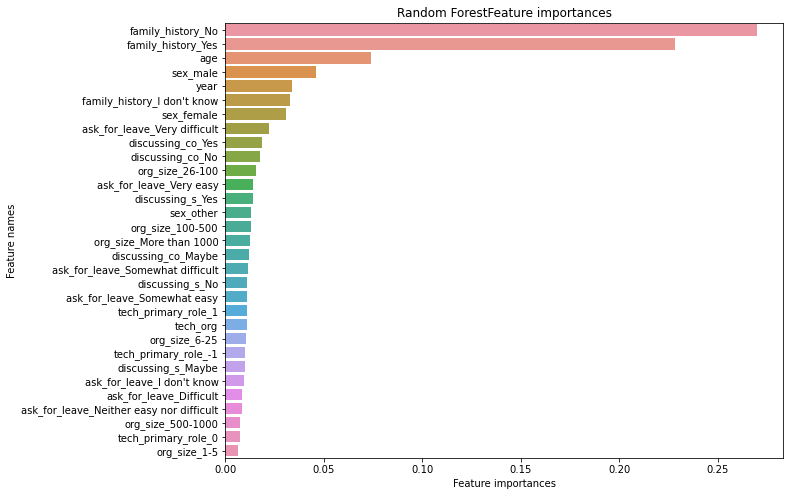

In [47]:
#Plotting model feature importances
plot_feature_importances(rf_model.feature_importances_, train_x.columns, 'Random Forest')

## Plots

<AxesSubplot:xlabel='sought_treatment', ylabel='count'>

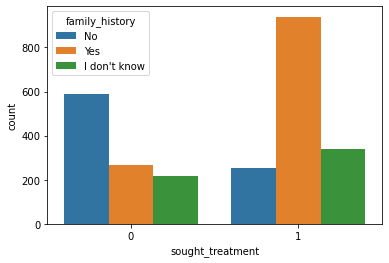

In [48]:
sns.countplot(x ='sought_treatment', hue = "family_history", data = surveys)


<AxesSubplot:xlabel='sought_treatment', ylabel='count'>

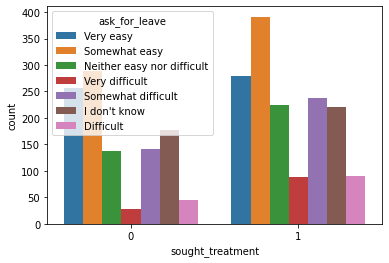

In [49]:
sns.countplot(x ='sought_treatment', hue = "ask_for_leave", data = surveys)


## Gender

<AxesSubplot:xlabel='sex', ylabel='count'>

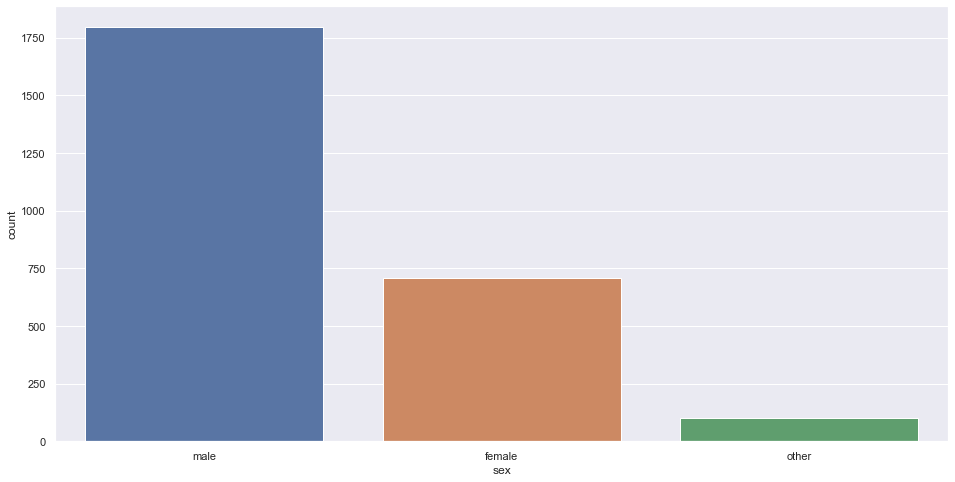

In [51]:
sns.set(rc = {'figure.figsize':(16,8)})
sns.countplot(x='sex', data=surveys)

## Mental health disorder

<AxesSubplot:xlabel='sought_treatment', ylabel='count'>

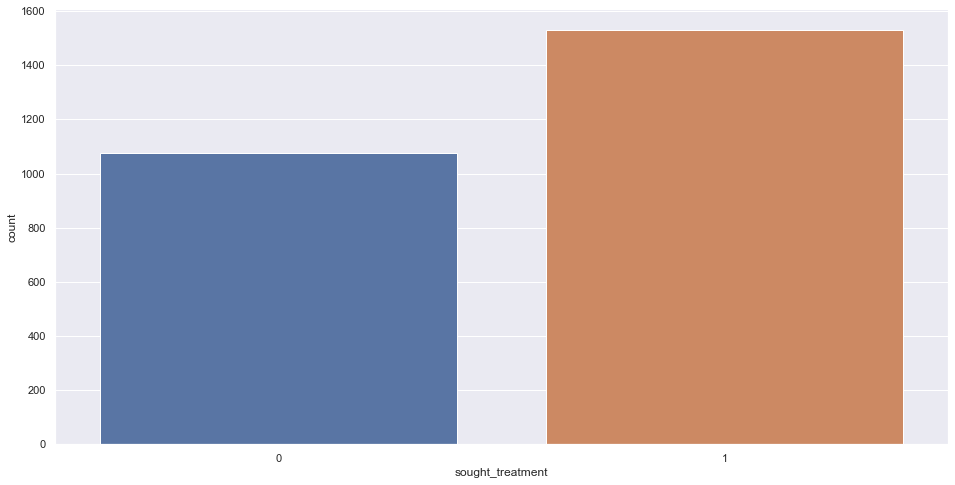

In [52]:
sns.countplot(x='sought_treatment', data=surveys)

## Company Size

<AxesSubplot:xlabel='org_size', ylabel='count'>

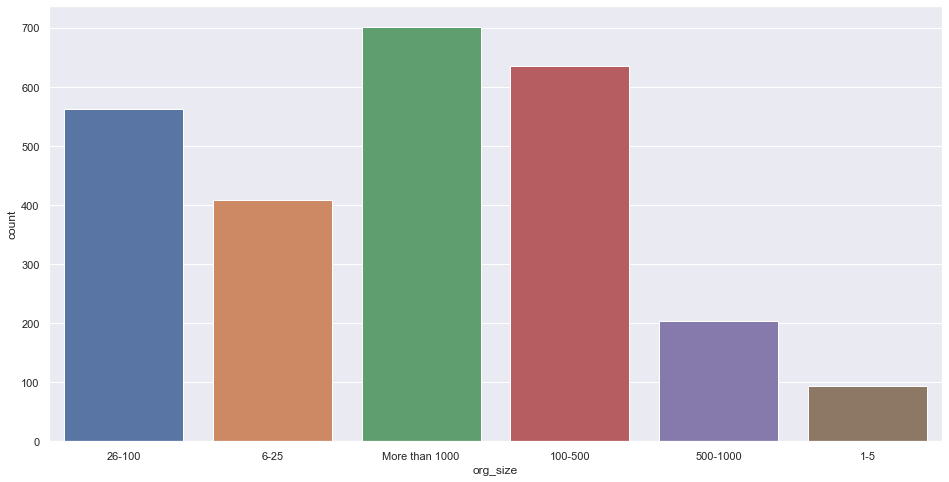

In [54]:
sns.countplot(x='org_size', data=surveys)

## Family history of mental health

<AxesSubplot:xlabel='family_history', ylabel='count'>

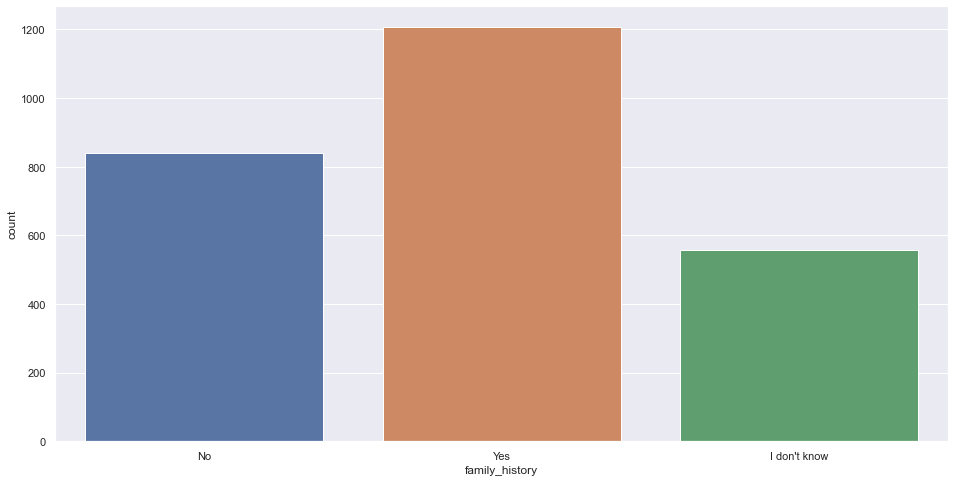

In [56]:
sns.countplot(x='family_history', data=surveys)

## Tech company

<AxesSubplot:xlabel='tech_org', ylabel='count'>

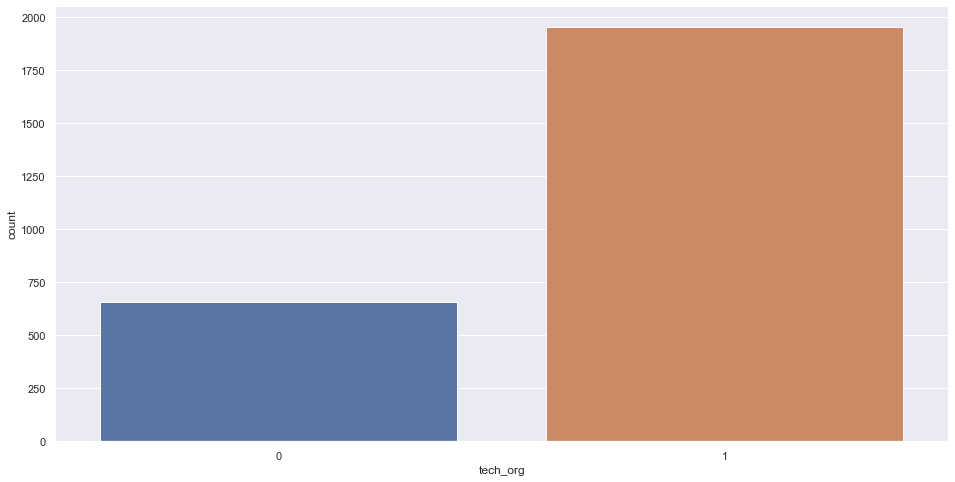

In [59]:
sns.countplot(x='tech_org', data=surveys)

## Tech role

<AxesSubplot:xlabel='tech_primary_role', ylabel='count'>

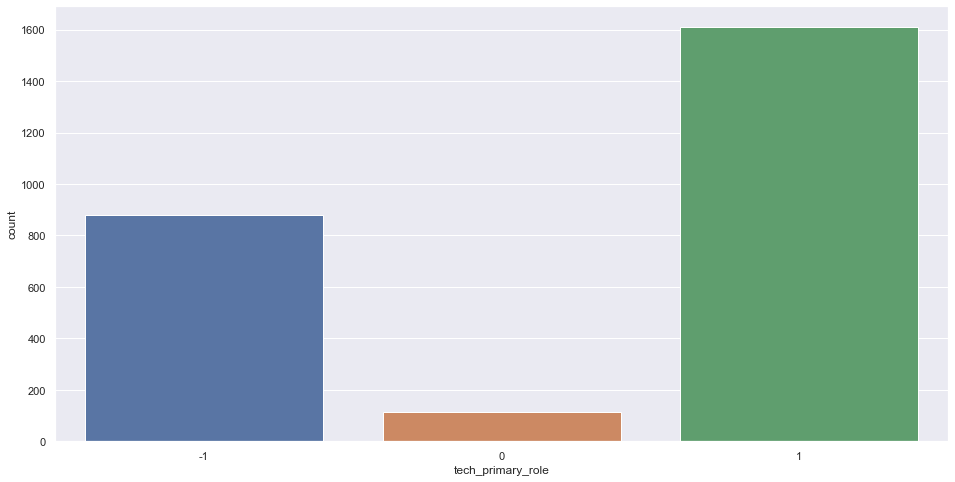

In [61]:
sns.countplot(x='tech_primary_role', data=surveys)

## If a mental health issue prompted you to request a medical leave from work, how easy or difficult would it be to ask for that leave?

<AxesSubplot:xlabel='ask_for_leave', ylabel='count'>

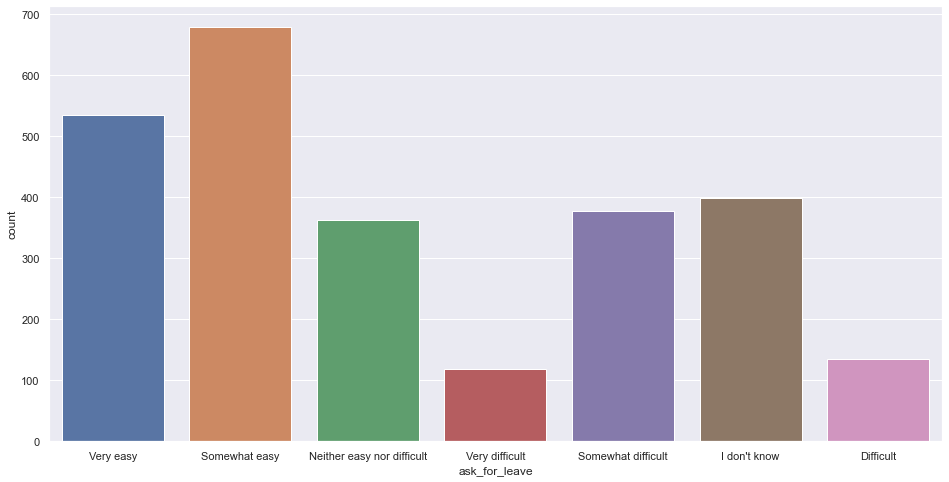

In [62]:
sns.countplot(x='ask_for_leave', data=surveys)

## Would you feel comfortable discussing a mental health issue with your coworkers?
Att göra: Undersöka värdena för denna variabel.

<AxesSubplot:xlabel='discussing_co', ylabel='count'>

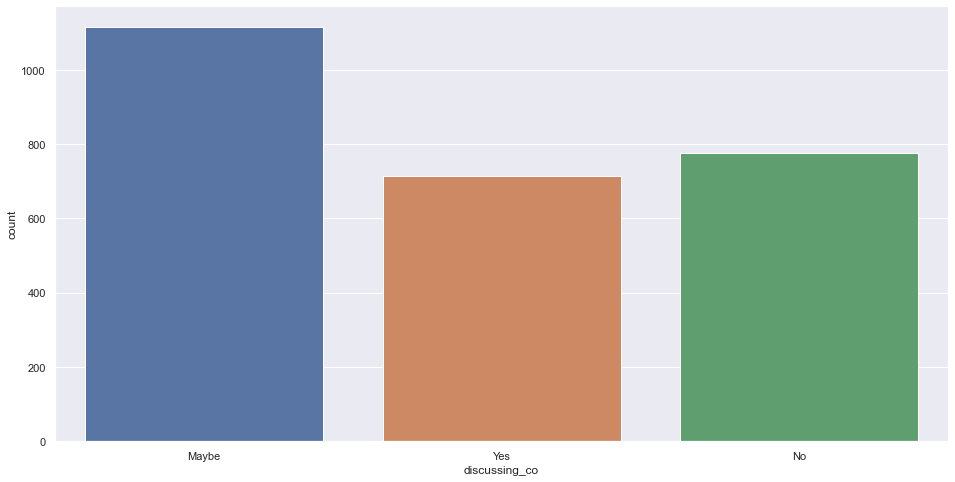

In [67]:
sns.countplot(x='discussing_co', data=surveys)

## Would you feel comfortable discussing a mental health issue with your direct supervisor(s)?
Att göra: Undersöka värdena för denna variabel.

<AxesSubplot:xlabel='discussing_s', ylabel='count'>

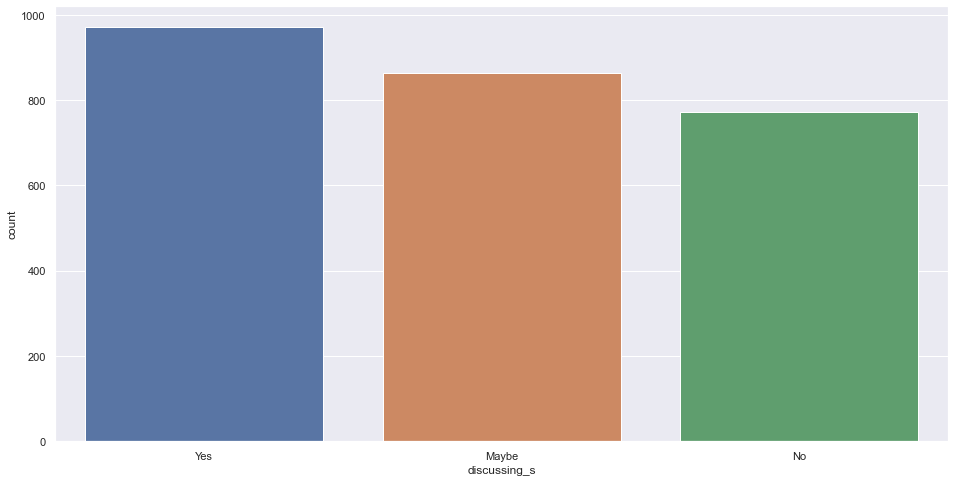

In [71]:
sns.countplot(x='discussing_s', data=surveys)